In [485]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Reference Model

In [486]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)

# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)
# Getting the time length
time = np.unique(results['time'].values)
T = len(time)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, T, M, C))
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
print (np.shape(ref_traj))

(10, 201, 62, 7)


Plotting 62 patches in a 7 x 9 grid


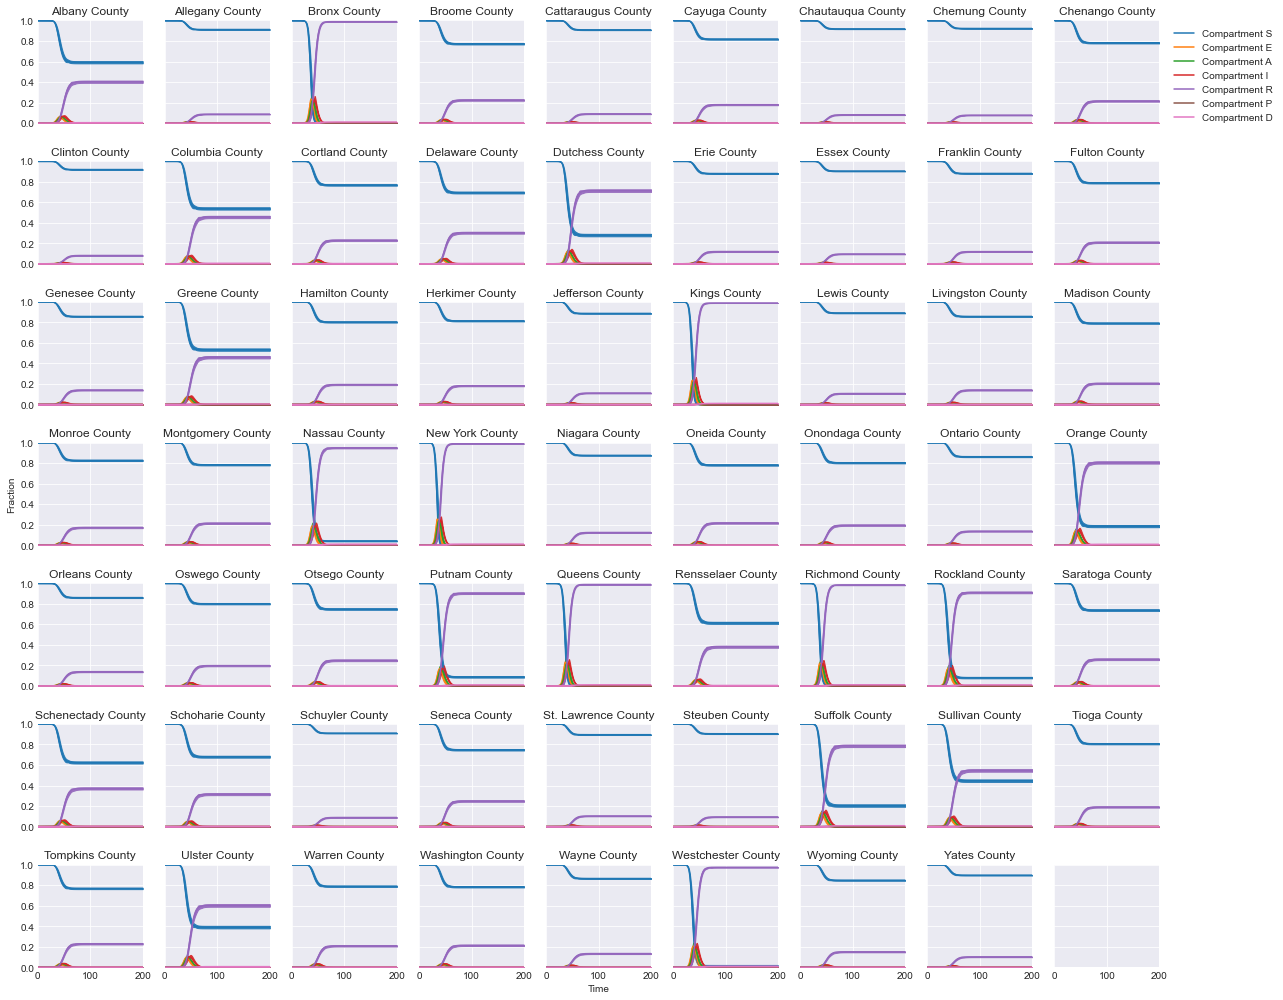

In [487]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.9, names=['S','E','A','I','R','P','D'])
plt.savefig('patch_quantile.png',dpi=400)
plt.show()

In [488]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

In [489]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

In [490]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
networkCounty = networkCounty[['ID','mobility_parameter']]
Mobility_martix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'ID']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'ID'] == 0:
            Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
            mobility_parameter_row = np.zeros(M)
    else:
         Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
assert (np.shape(Mobility_martix)==(M,M))
Mobility_martix_norm = Mobility_martix / np.sum(Mobility_martix, axis=1).reshape(M,1)

## Restraining a sample SEAIRPD to reference

In [491]:
# compartment parameters
compartments = ['E','A','I','R','P','D']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 5, 2)
tmat.add_transition('A', 'I', 3, 1)
tmat.add_transition('I', 'P', 5, 2)
tmat.add_transition('P', 'D', 5, 2)
tmat.add_transition('D', 'R', 5, 2)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.0001
hyper_pram.beta_high = 0.9
hyper_pram.beta_var = 0.1
hyper_pram.start_high = 0.01
# hyper_pram.start_var = 0.1
# hyper_pram.R_var = 0.001
hyper_pram.beta_start = 0.001
hyper_pram.start_mean = 0.001
# hyper_pram.start_scale = 0.1

start_logits = np.zeros((M,))
start_logits[:]=np.log(0.01)
param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )

[[0.8        0.2        0.         0.         0.         0.        ]
 [0.         0.66666667 0.33333333 0.         0.         0.        ]
 [0.         0.         0.8        0.         0.2        0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.8        0.2       ]
 [0.         0.         0.         0.2        0.         0.8       ]]


In [492]:
import tqdm
N = 50
batches = 16
outs = []
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, T)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

(800, 201, 62, 7)


## Make restraints from reference trajectory

87 0.4253157041559711 0.4253157041559711
24 2.3780207245462104e-05 2.3780207245462104e-05
108 0.42545232955074647 0.42545232955074647
66 0.40964296857192745 0.40964296857192745
38 0.015493191130129366 0.015493191130129366
122 0.4254531214127767 0.4254531214127767
136 0.42545316070350975 0.42545316070350975
59 0.366303343662358 0.366303343662358
59 0.0064952734447155805 0.0064952734447155805
45 0.05707742946318251 0.05707742946318251
17 1.043558436212753e-05 1.043558436212753e-05
3 0.0 0.0
66 0.0013134521083181065 0.0013134521083181065
38 0.0512578702433315 0.0512578702433315
24 0.0003160689682225051 0.0003160689682225051
52 0.025282879123200964 0.025282879123200964
59 0.013995041067532521 0.013995041067532521
3 0.0 0.0
31 0.0036144989122980672 0.0036144989122980672
10 9.235031624096221e-08 9.235031624096221e-08
66 0.0032790820187091818 0.0032790820187091818
45 0.06735925120651398 0.06735925120651398
38 0.037327199152681886 0.037327199152681886
24 0.0001304448261902567 0.000130444826190

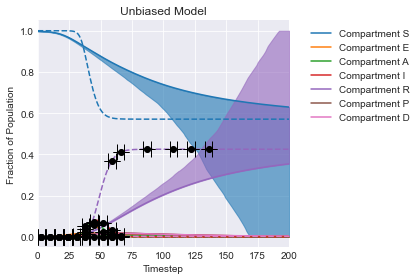

In [493]:
# Plotting restraints on reference traj
full_compartments = ['S'] + compartments
p = 1 # picking one trajectory from the parameter set
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,0], linestyle='--')
plt.title('Unbiased Model')

npoints =8
prior = maxentep.Laplace(0.1)
# cutting the ref_traj in half
restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:150,:,:], [0,4], npoints, prior, noise=0,time_average=7)
restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,3], npoints, prior, noise=0,time_average=7)
restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
plt.show()


In [494]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')

In [495]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [496]:
history = me_model.fit(trajs, batch_size=8,epochs=50, callbacks=[CustomCallback()])

Epoch 1/50
100/100 [==============================] - 0s 479us/step - loss: 0.0073 - weight-entropy: 1.9447
Epoch 2/50
100/100 [==============================] - 0s 539us/step - loss: 0.0066 - weight-entropy: 1.9553
Epoch 3/50
100/100 [==============================] - 0s 499us/step - loss: 0.0065 - weight-entropy: 1.9640
Epoch 4/50
100/100 [==============================] - 0s 489us/step - loss: 0.0068 - weight-entropy: 1.9721
Epoch 5/50
100/100 [==============================] - 0s 489us/step - loss: 0.0070 - weight-entropy: 1.9835
Epoch 6/50
100/100 [==============================] - 0s 489us/step - loss: 0.0069 - weight-entropy: 1.9766
Epoch 7/50
100/100 [==============================] - 0s 499us/step - loss: 0.0071 - weight-entropy: 1.9811
Epoch 8/50
100/100 [==============================] - 0s 469us/step - loss: 0.0076 - weight-entropy: 1.9909
Epoch 9/50
100/100 [==============================] - 0s 489us/step - loss: 0.0070 - weight-entropy: 1.9857
Epoch 10/50
100/100 [=======

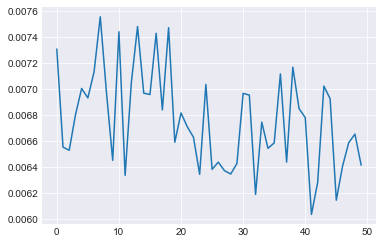

In [497]:
plt.plot(history.history['loss'])

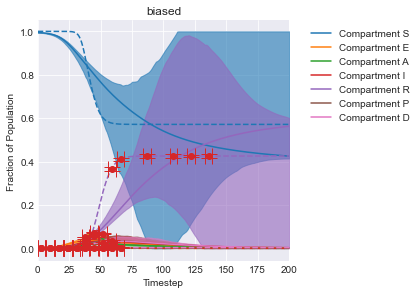

In [498]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(plt, me_model.lambdas[i], color='C3')
plt.tight_layout()
plt.title('biased')
plt.show()

In [499]:
weights = me_model.traj_weights
# plt.hist(weights)
# plt.show()
# plt.plot(me_model.lambdas.numpy(), 'o')

In [500]:
print (weights)

tf.Tensor(
[0.00097747 0.00083627 0.00219505 0.00219719 0.00206952 0.00083627
 0.00083627 0.00083627 0.00083733 0.00083627 0.00083627 0.00083627
 0.00213875 0.00087707 0.00083627 0.00214542 0.0008384  0.00083627
 0.00083627 0.00083627 0.00083627 0.00083627 0.00083897 0.00083627
 0.00083627 0.00083627 0.00083627 0.00083627 0.00083627 0.00222771
 0.00253561 0.00111314 0.00083627 0.00083627 0.00083627 0.00083627
 0.00083627 0.00083627 0.00083627 0.00272436 0.00154041 0.00235033
 0.00083627 0.00194423 0.00083627 0.00228413 0.00176788 0.00083627
 0.00112188 0.00089342 0.00242466 0.0022455  0.00240089 0.00083627
 0.00083627 0.00083627 0.00316646 0.00270452 0.00235762 0.00250819
 0.00083627 0.00083627 0.00096413 0.00083627 0.00083627 0.00083627
 0.00083627 0.00083627 0.00083627 0.00220418 0.0021578  0.00083627
 0.00253287 0.00083627 0.00083627 0.00083627 0.00083627 0.00083627
 0.00083627 0.00172833 0.00139929 0.00108992 0.00130164 0.00234223
 0.00252878 0.00224643 0.00232562 0.00083789 0.0026

## Algorithm 2

In [501]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), Mobility_martix_norm, tmat, name='unbiased_model',hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.Adam(0.01))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')

In [502]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=15, batch_size=32, epochs=8)

Epoch 1/8
2/2 [==============================] - 0s 997us/step - loss: 0.0128 - weight-entropy: 3.0945
Epoch 2/8
2/2 [==============================] - 0s 499us/step - loss: 0.0132 - weight-entropy: 3.1055
Epoch 3/8
2/2 [==============================] - 0s 515us/step - loss: 0.0123 - weight-entropy: 3.0935
Epoch 4/8
2/2 [==============================] - 0s 497us/step - loss: 0.0122 - weight-entropy: 3.0903
Epoch 5/8
2/2 [==============================] - 0s 498us/step - loss: 0.0122 - weight-entropy: 3.0865
Epoch 6/8
2/2 [==============================] - 0s 499us/step - loss: 0.0119 - weight-entropy: 3.0867
Epoch 7/8
2/2 [==============================] - 0s 997us/step - loss: 0.0148 - weight-entropy: 3.0845
Epoch 8/8
2/2 [==============================] - 0s 997us/step - loss: 0.0122 - weight-entropy: 3.0905
Epoch 1/8
2/2 [==============================] - 0s 3ms/step - loss: 9.7987 - R-dist-dist_loss: 10.7847 - T-dist-dist_loss: -0.1110 - rho-dist-dist_loss: -0.0168 - beta-dist_lo

2/2 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 0.2551
Epoch 7/8
2/2 [==============================] - 0s 980us/step - loss: 0.0127 - weight-entropy: 0.1270
Epoch 8/8
2/2 [==============================] - 0s 1ms/step - loss: 0.0319 - weight-entropy: 0.5217
Epoch 1/8
2/2 [==============================] - 0s 3ms/step - loss: 11.3428 - R-dist-dist_loss: 12.7734 - T-dist-dist_loss: -0.1477 - rho-dist-dist_loss: 0.0287 - beta-dist_loss: -1.3117
Epoch 2/8
2/2 [==============================] - 0s 4ms/step - loss: 11.4392 - R-dist-dist_loss: 12.3022 - T-dist-dist_loss: -0.1487 - rho-dist-dist_loss: 0.0236 - beta-dist_loss: -0.7378              
Epoch 3/8
2/2 [==============================] - 0s 4ms/step - loss: 10.5003 - R-dist-dist_loss: 11.9406 - T-dist-dist_loss: -0.1492 - rho-dist-dist_loss: 0.0205 - beta-dist_loss: -1.3117
Epoch 4/8
2/2 [==============================] - 0s 3ms/step - loss: 9.8547 - R-dist-dist_loss: 10.7329 - T-dist-dist_loss: -0.

2/2 [==============================] - 0s 3ms/step - loss: 9.9997 - R-dist-dist_loss: 11.1247 - T-dist-dist_loss: -0.0907 - rho-dist-dist_loss: -0.0883 - beta-dist_loss: -0.9461
Epoch 6/8
2/2 [==============================] - 0s 4ms/step - loss: 8.9614 - R-dist-dist_loss: 10.0982 - T-dist-dist_loss: -0.0952 - rho-dist-dist_loss: -0.0952 - beta-dist_loss: -0.9463
Epoch 7/8
2/2 [==============================] - 0s 3ms/step - loss: 7.9960 - R-dist-dist_loss: 9.1428 - T-dist-dist_loss: -0.0992 - rho-dist-dist_loss: -0.1020 - beta-dist_loss: -0.9456
Epoch 8/8
2/2 [==============================] - 0s 4ms/step - loss: 7.0959 - R-dist-dist_loss: 8.2528 - T-dist-dist_loss: -0.1026 - rho-dist-dist_loss: -0.1087 - beta-dist_loss: -0.9456
Epoch 1/8
2/2 [==============================] - 0s 519us/step - loss: 0.0408 - weight-entropy: nan
Epoch 2/8
2/2 [==============================] - 0s 985us/step - loss: 0.0274 - weight-entropy: nan
Epoch 3/8
2/2 [==============================] - 0s 998us/st

Epoch 6/8
2/2 [==============================] - 0s 999us/step - loss: 0.0399 - weight-entropy: nan
Epoch 7/8
2/2 [==============================] - 0s 985us/step - loss: 0.0418 - weight-entropy: nan
Epoch 8/8
2/2 [==============================] - 0s 985us/step - loss: 0.0232 - weight-entropy: nan
Epoch 1/8
2/2 [==============================] - 0s 3ms/step - loss: 14.4436 - R-dist-dist_loss: 15.8850 - T-dist-dist_loss: -0.1749 - rho-dist-dist_loss: -0.0963 - beta-dist_loss: -1.1702
Epoch 2/8
2/2 [==============================] - 0s 4ms/step - loss: 14.1690 - R-dist-dist_loss: 15.6108 - T-dist-dist_loss: -0.1746 - rho-dist-dist_loss: -0.0970 - beta-dist_loss: -1.1702
Epoch 3/8
2/2 [==============================] - 0s 4ms/step - loss: 13.6860 - R-dist-dist_loss: 15.1295 - T-dist-dist_loss: -0.1745 - rho-dist-dist_loss: -0.0990 - beta-dist_loss: -1.1701
Epoch 4/8
2/2 [==============================] - 0s 3ms/step - loss: 13.0454 - R-dist-dist_loss: 14.4920 - T-dist-dist_loss: -0.1745 

2/2 [==============================] - 0s 4ms/step - loss: 16.1552 - R-dist-dist_loss: 16.9732 - T-dist-dist_loss: -0.0350 - rho-dist-dist_loss: -0.0745 - beta-dist_loss: -0.7085
Epoch 4/8
2/2 [==============================] - 0s 4ms/step - loss: 15.3310 - R-dist-dist_loss: 16.1530 - T-dist-dist_loss: -0.0391 - rho-dist-dist_loss: -0.0787 - beta-dist_loss: -0.7042
Epoch 5/8
2/2 [==============================] - 0s 3ms/step - loss: 14.3320 - R-dist-dist_loss: 15.1677 - T-dist-dist_loss: -0.0438 - rho-dist-dist_loss: -0.0842 - beta-dist_loss: -0.7078
Epoch 6/8
2/2 [==============================] - 0s 4ms/step - loss: 13.2164 - R-dist-dist_loss: 14.5967 - T-dist-dist_loss: -0.0465 - rho-dist-dist_loss: -0.0875 - beta-dist_loss: -1.2463
Epoch 7/8
2/2 [==============================] - 0s 3ms/step - loss: 12.1732 - R-dist-dist_loss: 13.0273 - T-dist-dist_loss: -0.0536 - rho-dist-dist_loss: -0.0973 - beta-dist_loss: -0.7032
Epoch 8/8
2/2 [==============================] - 0s 3ms/step - lo

In [503]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

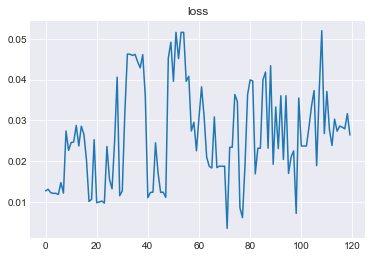

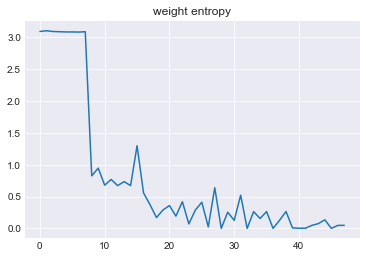

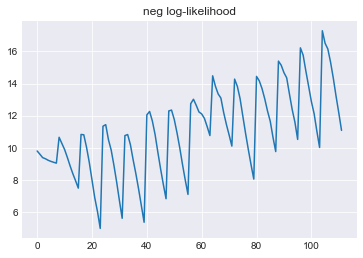

In [504]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [505]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-6.9077554]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-6.9077554]], dtype=float32)>])

In [506]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 62, 62)    7688        input_64[0][0]                   
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 62, 62)    0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 6, 6)      72          input_64[0][0]                   
_______________________________________________________________________________

In [507]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(62,) dtype=float32, numpy=
  array([ 0.52998394, -0.19867551, -0.11341484, -0.34019428,  1.124543  ,
         -0.49488255, -0.86493087, -0.02979992, -0.27488145, -1.0336415 ,
          0.33435005, -0.67769825, -0.51327336, -1.146756  ,  0.22880788,
          0.57292825, -0.3048462 ,  0.69853157, -0.31632423,  0.01400713,
          0.13867368, -0.03071305,  0.60422724,  0.1472198 ,  0.16623792,
         -0.9677974 , -0.2564772 , -0.70595944,  0.5270861 ,  0.34539068,
          0.27562225,  0.7669531 ,  0.07675792,  1.0095801 ,  0.01198549,
         -0.18736471, -0.2658274 , -0.47531617, -0.6082682 ,  0.8821343 ,
         -0.2752758 , -0.14384006,  0.437582  ,  0.37747467,  0.23971112,
         -0.10765354,  0.18251604, -0.15958606, -0.07535055, -0.27801618,
          1.0599675 , -0.6967169 ,  0.15258625,  0.19818391, -0.63205963,
          0.68611723,  0.22999096,  0.21612836,  0.2515221 ,  0.21910337,
          0.03321719,  0.24594663], dtype=float32)>],

In [508]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[ 0.23082174  0.12148051  0.3301962   0.11204316  0.2527219   0.38004404
  0.41882488  0.10105971  0.02406547 -0.0198654   0.05388634  0.07840649
  0.02649901 -0.00967938  0.05270514  0.00836786  0.00277175  0.04006837
  0.02412494  0.03077191  0.01193575 -0.04658204 -0.01355349  0.0309912
  0.0032432   0.05956631  0.05633105  0.05894512 -0.0257062   0.06503777
  0.02910336 -0.02775809  0.05212975  0.04346554  0.04420112  0.04872612
  0.05389765  0.05317889  0.0383788   0.03455399  0.04531219  0.03897626
  0.05335826  0.05596098  0.05668268  0.00102785  0.04405489  0.03358535] [-1.14464328e-01  6.36533136e-03 -2.03180779e-02 -2.25155801e-01
  1.67743377e-02  2.58094966e-02  6.07711338e-02 -2.26856828e-01
  2.37561967e-02 -2.17777025e-02  1.00289984e-02  3.82029265e-03
  2.56747697e-02 -1.66009068e-02  1.98644456e-02  8.19582026e-03
  5.20588318e-03  1.49791944e-03  1.13056377e-02  2.19104742e-03
  1.38240317e-02 -4.69201989e-02 -1.85491126e-02  9.11391433e-03
  1.13498594e-03  1.030325

In [509]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 6.5714025 after tuning nan


C:\ProgramData\Anaconda3\envs\maxentep\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


## Direct Regression of Model

In [510]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 0.01
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, Mobility_martix_norm, T, infect, 201, agreement)

In [511]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()

150/150 [==============================] - 19s 129ms/step - loss: 0.1372 - output_2_loss: 0.1372


## Visualizing results

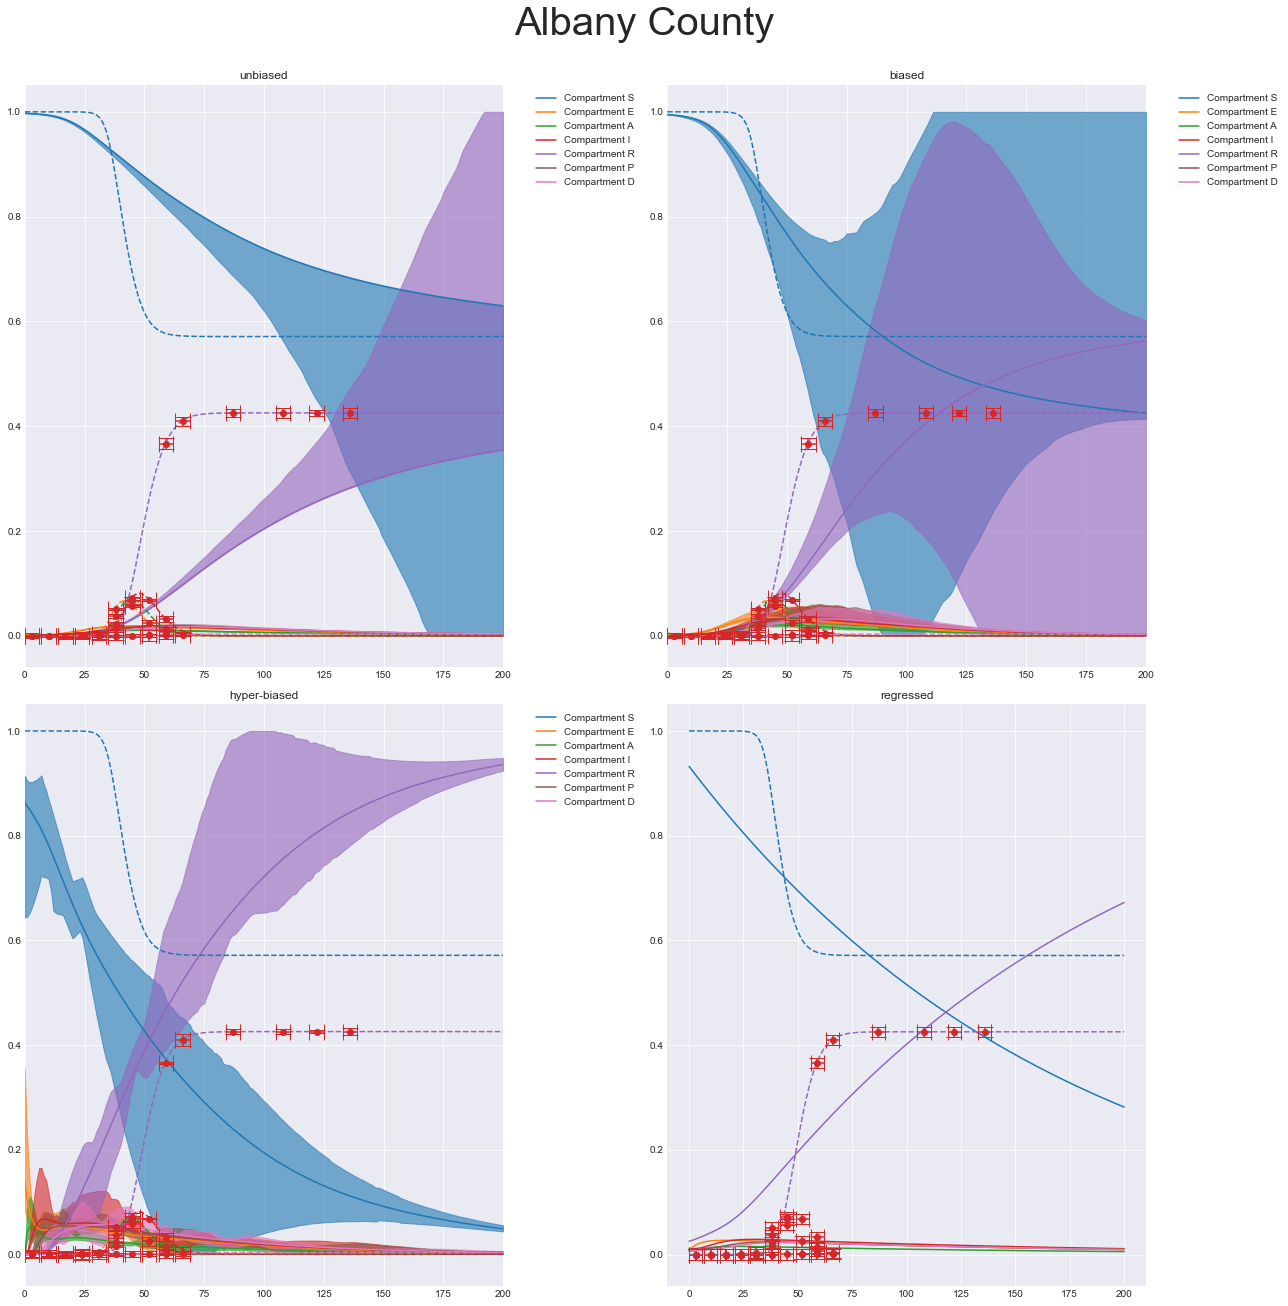

In [516]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Albany.png', dpi = 300)
plt.show()

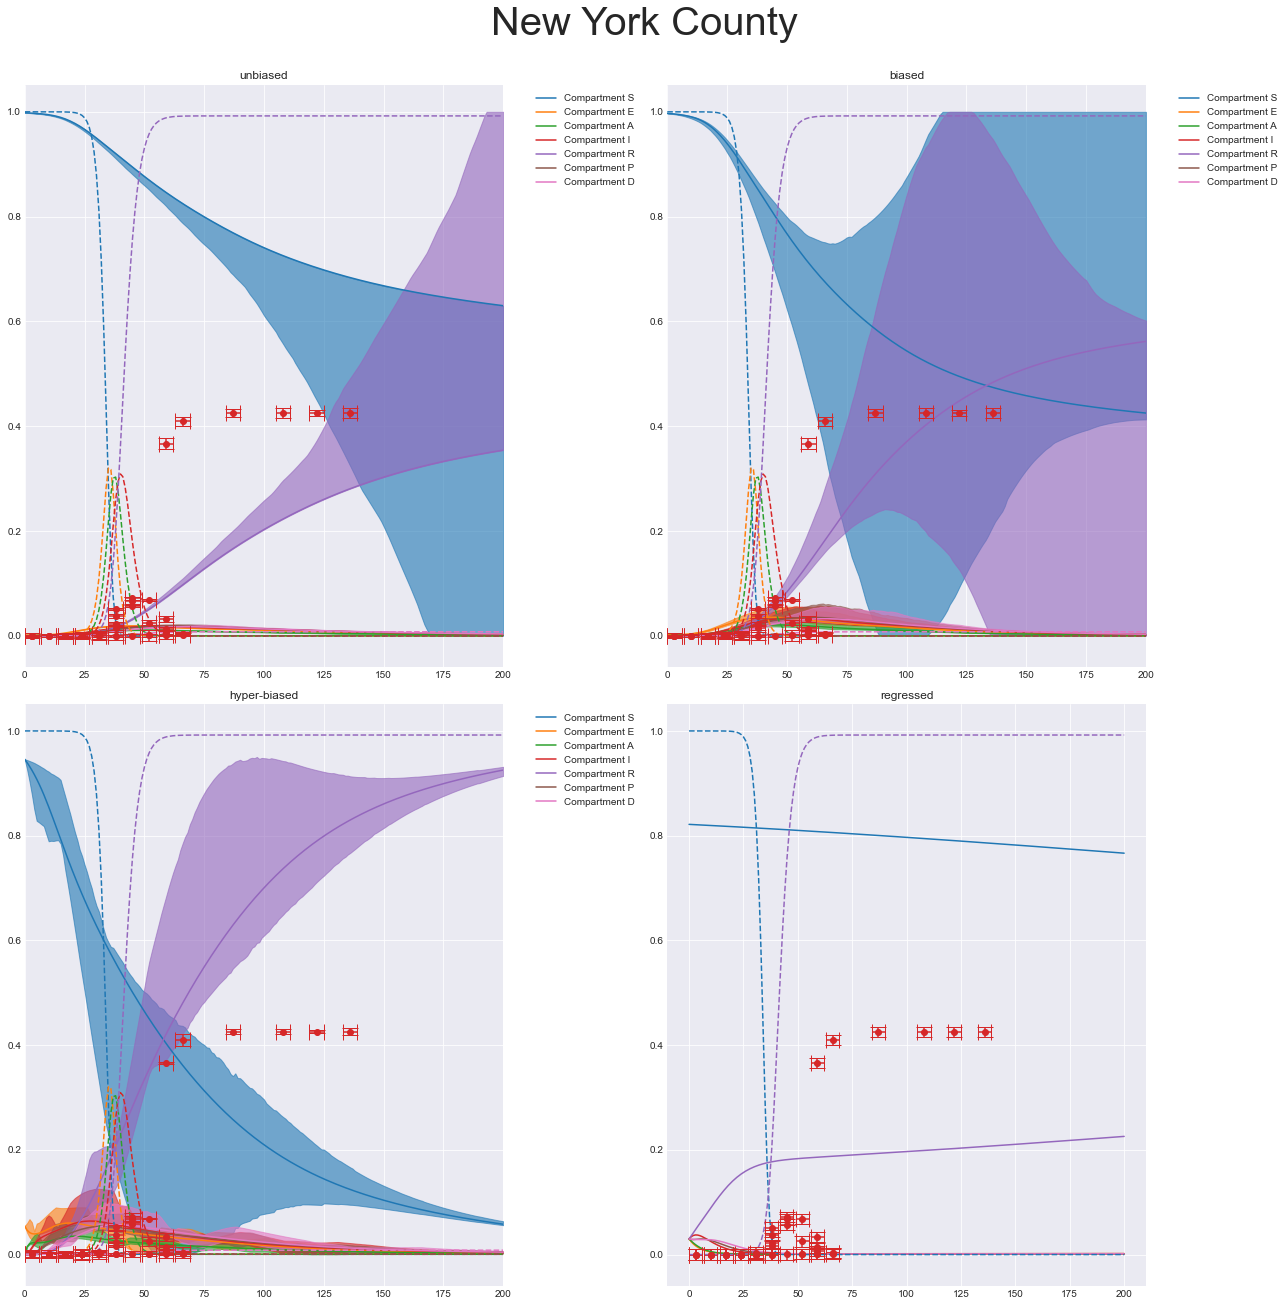

In [515]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_NY.png', dpi = 300)
plt.show()